In [1]:
import chess
import chess.engine
import random
import numpy as np
import subprocess
import tensorflow as tf
stockfish_path = 'stockfish\\stockfish-windows-x86-64-avx2.exe'

# this function will create our x (board)
def random_board(max_depth=200):
  board = chess.Board()
  depth = random.randrange(0, max_depth)

  for _ in range(depth):
    all_moves = list(board.legal_moves)
    random_move = random.choice(all_moves)
    board.push(random_move)
    if board.is_game_over():
      break

  return board

# this function will create our f(x) (score)
def stockfish_result(board, depth):
  with chess.engine.SimpleEngine.popen_uci(stockfish_path,startupinfo = subprocess.STARTUPINFO(dwFlags=subprocess.STARTF_USESHOWWINDOW)) as sf:
    result = sf.analyse(board, chess.engine.Limit(depth=depth))
    return result
  
# this function will create our f(x) (score)
  with chess.engine.SimpleEngine.popen_uci(stockfish_path,startupinfo = subprocess.STARTUPINFO(dwFlags=subprocess.STARTF_USESHOWWINDOW)) as sf:
    result = sf.analyse(board, chess.engine.Limit(depth=depth))
    score = result['score'].white().score()
    return score

In [2]:
print("Num GPUs Available: ", tf.config.list_physical_devices())

Num GPUs Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


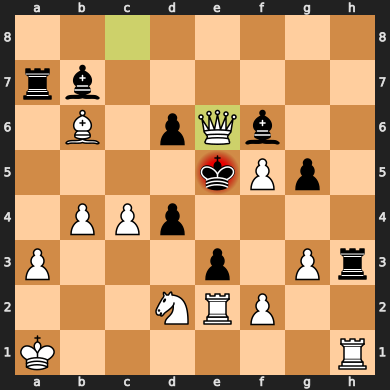

In [5]:
board = random_board()
board

In [6]:
print(stockfish_result(board, 15))

{'string': 'NNUE evaluation using nn-b1a57edbea57.nnue', 'depth': 0, 'score': PovScore(Mate(-0), BLACK)}


Exploring the chess engine package

In [7]:
print(board.legal_moves)
print(chess.PIECE_TYPES)
for piece in chess.PIECE_TYPES:
    print(board.pieces(1, chess.WHITE))
    print(board.pieces(1, chess.BLACK))

<LegalMoveGenerator at 0x27f449f1590 ()>
range(1, 7)
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . 1 . .
. 1 1 . . . . .
1 . . . . . 1 .
. . . . . 1 . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . 1 . . . .
. . . . . . 1 .
. . . 1 . . . .
. . . . 1 . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . 1 . .
. 1 1 . . . . .
1 . . . . . 1 .
. . . . . 1 . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . 1 . . . .
. . . . . . 1 .
. . . 1 . . . .
. . . . 1 . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . 1 . .
. 1 1 . . . . .
1 . . . . . 1 .
. . . . . 1 . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . 1 . . . .
. . . . . . 1 .
. . . 1 . . . .
. . . . 1 . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . 1 . .
. 1 1 . . . . .
1 . . . . . 1 .
. . . . . 1 . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . 1 . . . .
. .

The Idea is that the Deep Learning Network will predict this score based on the positions of the pieces on the board.

importing keras to create a model & adding a convolution layer to the newly created model

In [2]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Dropout
from tensorflow.keras import Sequential
from keras.regularizers import l2

def build_model_custom():
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(8, 8, 14), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),  # Dropout after batch normalization, first conv layer
        
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),  # Increased dropout for the deeper layer

        Flatten(),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.6),  # Higher dropout before the final dense layers

        Dense(4096, activation='softmax')  # Outputs one of all possible moves
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    return model

model = build_model_custom()

c:\Users\timho\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [41]:
def board_to_input(board):
    # Creating an 8x8x14 numpy array to represent the board
    board_state = np.zeros((8, 8, 14), dtype=np.float32)
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            index = piece.piece_type - 1 + (6 * (piece.color == chess.BLACK))
            board_state[square // 8, square % 8, index] = 1
    return board_state

def input_to_board(board_state):
    # Create a new empty chess board
    board = chess.Board(None)  # None to initialize an empty board
    
    piece_types = {
        0: chess.PAWN,
        1: chess.KNIGHT,
        2: chess.BISHOP,
        3: chess.ROOK,
        4: chess.QUEEN,
        5: chess.KING,
    }

    # Iterate over all positions in the 8x8x14 board state
    for i in range(8):
        for j in range(8):
            for k in range(14):
                if board_state[i, j, k] == 1:
                    piece_type = piece_types[k % 6]
                    color = chess.WHITE if k < 6 else chess.BLACK
                    piece = chess.Piece(piece_type, color)
                    square = chess.square(j, i)  # Convert 2D board index to chess square
                    board.set_piece_at(square, piece)
    
    return board


def move_to_index(move):
    # Convert chess move to index
    from_square = move.from_square
    to_square = move.to_square
    move_index = from_square * 64 + to_square
    return move_index

def index_to_move(index):
    # Convert index back to chess move
    from_square = index // 64
    to_square = index % 64
    move = chess.Move(from_square, to_square)
    return move
    # if move in board.legal_moves:
    #     return move
    # else:
    #     return None

In [7]:
def read_games_from_pgn(pgn_path, num_games):
    with open(pgn_path, "r", encoding="utf-8") as pgn_file:
        i = 0
        while i < num_games:
            game = chess.pgn.read_game(pgn_file)
            if game is None:
                break
            yield game
            i += 1

In [3]:
import io
import chess.pgn

def read_boards_from_pgn(pgn_path, num_boards, start=0):
    boards = []
    with open(pgn_path, "r", encoding="utf-8") as pgn_file:
        games_count = 0
        for _ in range(start): # skip to start
             chess.pgn.read_game(pgn_file) 
        while len(boards) < num_boards:
            game = chess.pgn.read_game(pgn_file)
            if game is not None:
                games_count += 1
                boards.extend(get_board_states_from_game(game))
        
    return boards, (start + games_count)

def get_board_states_from_game(game):
    board_states = []
    board = game.board()
    for move in game.mainline_moves():
        board.push(move)
        board_states.append(board.copy())  # Copy the current board state
    return board_states

In [4]:
import hashlib
import pandas as pd

def hash_array(arr):
    return hashlib.sha256(arr).hexdigest()

def dropDuplicatesOnMutable(df_dup: pd.DataFrame, mutableCol="board"):
    new_col = "temp_hash_column"
    df_dup[new_col] = df_dup[mutableCol].apply(lambda x: hash_array(x.tobytes()))
    # Now check for duplicates based on the hash
    duplicates = df_dup.drop_duplicates(subset=new_col, keep=False)
    print("Omited total of: ", df_dup.size - duplicates.size)
    print(duplicates[new_col].size)
    duplicates.drop([new_col], axis=1, inplace=True)
    return duplicates

Add player games from lichess:

In [ ]:
import random
import pandas as pd
import numpy
def generate_data(pgn_path, save_to, num_pgn_boards, start_offset=0, depth=10, batch=250):
    data = []
    offset = start_offset
    iterations_divider = batch
    max_iterations = max(num_pgn_boards // iterations_divider, 1)
    i = 0
    while(i < max_iterations):
        print("while start", num_pgn_boards // max_iterations, offset)
        # Process games from PGN
        boards, offset = read_boards_from_pgn(pgn_path, num_pgn_boards // max_iterations, offset)
        for board in boards:
            result = stockfish_result(board, depth)
            if 'pv' in result:
                pv = result['pv']
                move_index = move_to_index(pv[0])
                input_tensor = board_to_input(board)
                data.append((input_tensor.flatten(), move_index))
        print ("end pgn")
        df = pd.DataFrame(data, columns=['board', 'move_index'])
        df = dropDuplicatesOnMutable(df)
        df.to_csv(save_to, mode='a', header=False, index=False)
        i += 1
        print("Ended at:", offset)

generate_data('lichess_db_standard_rated_2016-03.pgn', 'chess_data_v3.csv', 50000, start_offset=2595, depth=15, batch=750)
# last skipped to 14000 games of lichess_db_standar_rated_2016 to chess_data_cont
# last stopped ad index 57000 on lichess_db_standar_rated_2016 to chess_data_v1


TRAINING

In [11]:
expected_elements = 8 * 8 * 14  # Expected number of elements for each board

def check_and_convert_string(s):
    items = s[1:-1].replace('\n', '').split(' ')
    if len(items) != expected_elements:
        print(f"Incorrect number of elements: expected {expected_elements}, got {len(items)}")
        return None
    else: return np.array([float(item) for item in items], dtype=float)
    


In [20]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import pandas as pd

def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1))
    
    
def train_model(model=build_model_custom(), epochs=10, learning_rate=0.001, train_data=None):
    trimmed_df = pd.DataFrame(list())
    # Load the dataset
    if train_data is not None:
        trimmed_df = train_data
        print(trimmed_df.size)
    else :
        df = pd.read_csv('chess_data_v3.csv').drop_duplicates()
        df_re = pd.read_csv('chess_data_reinforced_v1.csv').drop_duplicates()
        print(df.size, df_re.size)
        df = pd.concat([df, df_re])
        trimmed_df = df.sample(frac=1, random_state=69).drop_duplicates()
        print(trimmed_df.size)
    # Prepare inputs and labels
    X = np.array(list(trimmed_df['board'].apply(lambda x: np.fromstring(x[1:-1], sep=' ')).values)).reshape(-1, 8, 8, 14)
    #df['processed_board'] = df['board'].apply(check_and_convert_string)
    #df_filtered = df.dropna(subset=['processed_board'])
    #X = np.array(list(df_filtered['processed_board'].values)).reshape(-1, 8, 8, 14)

    y = trimmed_df['move_index'].values

    # Convert labels to one-hot encoding
    y = to_categorical(y, num_classes=4096)
    

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 
    optimizer = Adam(learning_rate=learning_rate) #default 0.001
    model.compile(optimizer=optimizer, loss='categorical_crossentropy')
    callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=256, validation_data=(X_test, y_test), callbacks=[callback])
    
    # Save the model
    model.save('chess_model_v2.keras')
    return X_test, y_test

model = build_model_custom()#load_model('chess_model_v2.keras')
X_test, y_test = train_model(model=model, epochs=25, learning_rate=0.0005)



c:\Users\timho\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112346 2148
114462
Epoch 1/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 8.2492 - val_loss: 7.0421 - learning_rate: 5.0000e-04
Epoch 2/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 6.4785 - val_loss: 6.3142 - learning_rate: 5.0000e-04
Epoch 3/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 5.6827 - val_loss: 5.6813 - learning_rate: 5.0000e-04
Epoch 4/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 5.2003 - val_loss: 5.3897 - learning_rate: 5.0000e-04
Epoch 5/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 4.8165 - val_loss: 5.2431 - learning_rate: 5.0000e-04
Epoch 6/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 4.5260 - val_loss: 5.1422 - learning_rate: 5.0000e-04
Epoch 7/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 4.3053 - val_loss: 5.0846 - learning_rate: 5.0000e-04
Epoch 8/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 4.1230 - val_loss: 5.0532 - learning_rate: 5.0000e-04
Epoch 9/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss:

In [22]:
print(len(X_test), len(y_test))

11447 11447


Get accuracy of model:

In [74]:
from tensorflow import keras
m = keras.metrics.Accuracy()
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)
truth = np.argmax(y_test, axis=1)
m.update_state(predictions, truth)
print(m.result().numpy())


358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
0.104219444


Note:

last tested result is about 10% accuracy on 11447 test boards
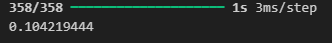

considering that our model is outputting a 4096x4096 matrix and needs to find the one right output, this result indicates "learning" of some sort

however to actually use this model a lot of optimizations would have to be made
A suggestion would be instead of weighing all possible moves, one could simply evaluate a board with a number and choose the board with the highest/lowest number of all boards resulting due to a legal move

Using the model

In [23]:
import numpy as np
import chess
import chess.engine
from tensorflow.keras.models import load_model

def minimax_eval(board):
  board3d = split_dims(board)
  board3d = numpy.expand_dims(board3d, 0)
  return model(board3d)[0][0]


def minimax(board, depth, alpha, beta, maximizing_player):
  if depth == 0 or board.is_game_over():
    return minimax_eval(board)
  
  if maximizing_player:
    max_eval = -numpy.inf
    for move in board.legal_moves:
      board.push(move)
      eval = minimax(board, depth - 1, alpha, beta, False)
      board.pop()
      max_eval = max(max_eval, eval)
      alpha = max(alpha, eval)
      if beta <= alpha:
        break
    return max_eval
  else:
    min_eval = numpy.inf
    for move in board.legal_moves:
      board.push(move)
      eval = minimax(board, depth - 1, alpha, beta, True)
      board.pop()
      min_eval = min(min_eval, eval)
      beta = min(beta, eval)
      if beta <= alpha:
        break
    return min_eval

def get_ai_move(model_local, board):
    legal_moves = list(board.legal_moves)
    move_indices = [move_to_index(move) for move in legal_moves]  # Convert legal moves to indices
    
    input_tensor = np.expand_dims(board_to_input(board), 0)  # Prepare the board state for the model
    probabilities = model_local.predict(input_tensor)[0]  # Get the softmax output probabilities
    
    # Filter probabilities to only include those for legal moves
    legal_probs = [(prob, move) for prob, move in zip(probabilities, legal_moves) if move_to_index(move) in move_indices]

    # Find the move with the highest probability among legal moves
    best_move = max(legal_probs, key=lambda x: x[0])[1] if legal_probs else None

    return best_move

In [ ]:
board = chess.Board()

with chess.engine.SimpleEngine.popen_uci(stockfish_path) as engine:
    while not board.is_game_over():
        move = get_ai_move(model, board)
        board.push(move)
        print(board)

        if board.is_game_over():
            print('Game over')
            break

        result = engine.play(board, chess.engine.Limit(time=0.1))
        board.push(result.move)
        print(board)

        if board.is_game_over():
            print('Game over')
            break

In [21]:
import chess.pgn
from tensorflow.keras import models

def play_stockfish(board, model, engine_path):
    with chess.engine.SimpleEngine.popen_uci(engine_path, startupinfo = subprocess.STARTUPINFO(dwFlags=subprocess.STARTF_USESHOWWINDOW)) as engine:
        game = chess.pgn.Game()
        game.headers["Event"] = "Neural Net Bot vs Stockfish Game"
        game.headers["White"] = "Neural Net Bot"
        game.headers["Black"] = "Stockfish"
        node = game
        while not board.is_game_over():
            move = get_ai_move(model, board)
            board.push(move)
            node = node.add_variation(move)

            if board.is_game_over():
                break

            result = engine.play(board, chess.engine.Limit(time=0.2))
            board.push(result.move)
            node = node.add_variation(result.move)
            
        return game

model = load_model('chess_model_v2.keras')
board = chess.Board()


game = play_stockfish(board, model, stockfish_path)

# export pgn
with open("game.pgn", "w", encoding="utf-8") as pgn_file:
        exporter = chess.pgn.FileExporter(pgn_file)
        game.accept(exporter)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Creating a Reinforced Dataset by playing against stockfish

In [10]:
# only execute if file chess_data_reinforced.csv does not exist
# pd.DataFrame([('board', 'move_index')]).to_csv('chess_data_reinforced.csv', mode='w', header=False, index=False)

In [15]:
import chess.pgn
from tensorflow.keras import models

def evaluate_model_moves(board, model, engine_path):
    data = []
    with chess.engine.SimpleEngine.popen_uci(engine_path, startupinfo = subprocess.STARTUPINFO(dwFlags=subprocess.STARTF_USESHOWWINDOW)) as engine:
        game = chess.pgn.Game()
        game.headers["Event"] = "Neural Net Bot vs Stockfish Game"
        game.headers["White"] = "Neural Net Bot"
        game.headers["Black"] = "Stockfish"
        node = game
        while not board.is_game_over():
            # add best move to dataset
            temp_board = board
            result = engine.play(board, chess.engine.Limit(time=0.2))
            move_index = move_to_index(result.move)
            input_tensor = board_to_input(temp_board)
            data.append((input_tensor.flatten(), move_index))

            # make ai move:
            move = get_ai_move(model, board)
            board.push(move)
            node = node.add_variation(move)
            if board.is_game_over():
                break
            result = engine.play(board, chess.engine.Limit(time=0.2))
            board.push(result.move)
            node = node.add_variation(result.move)
    return data, game

In [ ]:
model = load_model('chess_model_v2.keras')

data, game = evaluate_model_moves(chess.Board(), model, stockfish_path)

df = pd.DataFrame(data, columns=['board', 'move_index'])
df.to_csv('chess_data_reinforced.csv', mode='a', header=False, index=False)

Stockfish vs Stockfish dataset generation

In [15]:
import chess
import chess.pgn
import chess.engine
import pandas as pd

def evaluate_stockfish_moves(board, engine_path):
    data = []
    with chess.engine.SimpleEngine.popen_uci(engine_path) as engine:
        game = chess.pgn.Game()
        game.headers["Event"] = "Stockfish vs Stockfish Game"
        game.headers["White"] = "Stockfish"
        game.headers["Black"] = "Stockfish"
        node = game

        while not board.is_game_over():
            # white
            result_white = engine.play(board, chess.engine.Limit(time=0.2))
            move_index = move_to_index(result_white.move)
            input_tensor = board_to_input(board)
            data.append((input_tensor.flatten(), move_index))
            board.push(result_white.move)
            node = node.add_variation(result_white.move)
        

            if board.is_game_over():
                break

            # black
            result_black = engine.play(board, chess.engine.Limit(time=0.2))
            move_index = move_to_index(result_black.move)
            input_tensor = board_to_input(board)
            data.append((input_tensor.flatten(), move_index))
            board.push(result_black.move)
            node = node.add_variation(result_black.move)
            

    return data, game
            
        



In [16]:
data, game = evaluate_stockfish_moves(chess.Board(), stockfish_path)

df = pd.DataFrame(data, columns=['board', 'move_index'])
df.to_csv('chess_data_reinforced_v1.csv', mode='a', header=False, index=False) 

Stockfish Dataset Creation - Loop

In [18]:
# for _ in range(3):
    #model = load_model('chess_model_v2.keras')
random_choices = list()
for _ in range(10):
    board = chess.Board()
    random_move = random.choice(list(board.legal_moves))
    while random_move in random_choices and len(random_choices) < 20:  # all 16 pawn moves plus 4 knight moves
        random_move = random.choice(list(board.legal_moves))
    board.push(random_move)
    data, game = evaluate_stockfish_moves(board, stockfish_path)
    df_data = dropDuplicatesOnMutable(pd.DataFrame(data, columns=['board', 'move_index']))
    df_data.to_csv('chess_data_reinforced_v1.csv', mode='a', header=False, index=False)
    # train_model(epochs=3, learning_rate=0.00001, train_data=pd.read_csv('chess_data_reinforced.csv').sample(frac=1, random_state=42))



Omited total of:  78
72


C:\Users\timho\AppData\Local\Temp\ipykernel_21904\2860310324.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicates.drop([new_col], axis=1, inplace=True)


Omited total of:  120
80


C:\Users\timho\AppData\Local\Temp\ipykernel_21904\2860310324.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicates.drop([new_col], axis=1, inplace=True)


Omited total of:  72
70


C:\Users\timho\AppData\Local\Temp\ipykernel_21904\2860310324.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicates.drop([new_col], axis=1, inplace=True)


Omited total of:  147
113


C:\Users\timho\AppData\Local\Temp\ipykernel_21904\2860310324.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicates.drop([new_col], axis=1, inplace=True)


Omited total of:  102
211


C:\Users\timho\AppData\Local\Temp\ipykernel_21904\2860310324.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicates.drop([new_col], axis=1, inplace=True)


Omited total of:  0
181
Omited total of:  30
199


C:\Users\timho\AppData\Local\Temp\ipykernel_21904\2860310324.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicates.drop([new_col], axis=1, inplace=True)


Omited total of:  48
52


C:\Users\timho\AppData\Local\Temp\ipykernel_21904\2860310324.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicates.drop([new_col], axis=1, inplace=True)


KeyboardInterrupt: 